In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d
from scipy.spatial.distance import cdist
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

h:\Estudos\Codigos\CienciaDeDados\Semin-rio-Modelos---Ciencias-da-Computa-o\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset
Usar dataset real (Kaggle, UCI ML Repository, ou sklearn.datasets) com no mínimo 500
observações. Incluir: EDA básico, pré-processamento (se necessário), treinamento e predição
do modelo, e comparação com baseline (Regressão Linear/Logística).

## Dataset escolhido

**Soybean Seeds🌱Classification Dataset**

O conjunto de dados inclui imagens de cinco tipos de sementes de soja individuais, totalizando 5513: intacta, manchada, imatura, quebrada e com danos à pele. As imagens individuais da soja (227x227 pixels) foram geradas a partir das imagens originais da soja (3072x2048 pixels) por meio de um algoritmo de processamento de imagem. E esses cinco tipos de imagens de soja foram classificados de acordo com o Padrão de Classificação da Soja (GB1352-2009).

As classes são
1. Broken
2. Immature
3. Intact
4. Skin Damaged
5. Spotted


In [2]:
#Baixar o dataset
path = kagglehub.dataset_download("aryashah2k/soybean-seedsclassification-dataset")
print(path)


C:\Users\Danil\.cache\kagglehub\datasets\aryashah2k\soybean-seedsclassification-dataset\versions\1


In [3]:
# Funções de extração de características
def lpq(img, winSize=7, decorr=1, mode='nh'):
    rho=0.90
    STFTalpha=1/winSize
    convmode='valid'
    img=np.float64(img)
    r=(winSize-1)/2
    x=np.arange(-r,r+1)[np.newaxis]
    w0=np.ones_like(x)
    w1=np.exp(-2*np.pi*x*STFTalpha*1j)
    w2=np.conj(w1)

    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    if decorr == 1:
        xp, yp = np.meshgrid(np.arange(1, winSize + 1), np.arange(1, winSize + 1))
        pp = np.column_stack((yp.flatten(), xp.flatten()))
        dd = cdist(pp, pp)
        C = rho ** dd

        q1 = w0.reshape((winSize,1))@w1.reshape((1,winSize))
        q2 = w1.reshape((winSize,1))@w0.reshape((1,winSize))
        q3 = w1.reshape((winSize,1))@w1.reshape((1,winSize))
        q4 = w1.reshape((winSize,1))@w2.reshape((1,winSize))
        
        M = np.vstack((q1.real.T.ravel(), q1.imag.T.ravel(), q2.real.T.ravel(), q2.imag.T.ravel(),
                       q3.real.T.ravel(), q3.imag.T.ravel(), q4.real.T.ravel(), q4.imag.T.ravel()))
        
        D = np.dot(M,C).dot(M.T)
        A = np.diag([1.000007, 1.000006, 1.000005, 1.000004, 1.000003, 1.000002, 1.000001, 1])
        U, S, V = np.linalg.svd(np.dot(A, D).dot(A))
        V = V.T

        freqRespShape = freqResp.shape
        freqResp = freqResp.reshape((-1, freqResp.shape[2]))
        freqResp = np.dot(V.T, freqResp.T).T
        freqResp = freqResp.reshape(freqRespShape)
    
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(257))[0]
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc


def lbp(image : np.ndarray,
        P : int = 8,
        R : int = 2,
        method : Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform'):

    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    desc = local_binary_pattern(image, P, R, method=method)
    n_bins = int(desc.max() + 1)
    hist, _ = np.histogram(desc, density=True, bins=n_bins, range=(0, n_bins))
    return hist

In [4]:
# Extração de características e criação do dataset CSV

base_dir = path

classes = {
    1: 'Broken Soybeans',
    2: 'Immature Soybeans',
    3: 'Intact Soybeans',
    4: 'Skin-damaged Soybeans',
    5: 'Spotted Soybeans'
}

features = []

for label, dir_name in classes.items():
    dir_path = os.path.join(base_dir, dir_name)
    for filename in os.listdir(dir_path):
        if filename.endswith(".bmp"):
            img_path = os.path.join(dir_path, filename)
            gray_img = imread(img_path, as_gray=1)
            gray_img_u = img_as_ubyte(gray_img)

            hist_lbp = lbp(gray_img_u)
            hist_lbp = hist_lbp.astype("float")
            hist_lbp /= (hist_lbp.sum() + 1e-6)
            hist_lbp = np.insert(hist_lbp, 0, label)

            hist_lpq = lpq(gray_img, mode='nh')
            combined = np.concatenate((hist_lbp, hist_lpq))
            features.append(combined)

# Criar DataFrame e salvar
df_features = pd.DataFrame(features)
df_features.to_csv('./features_full.csv', index=False)
print(f"Features extraídas: {df_features.shape}")

Features extraídas: (5513, 316)


Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5513 entries, 0 to 5512
Columns: 316 entries, label to 315
dtypes: float64(316)
memory usage: 13.3 MB
None 

Dimensões do dataset: (5513, 316)
Amostra dos dados:


,label,1,2,3,4,5,6,7,8,9,...,306,307,308,309,310,311,312,313,314,315
0,1.0,0.031477,0.008384,0.002445,0.008170,0.003105,0.008461,0.001669,0.006113,0.002600,...,0.002989,0.003276,0.003215,0.001966,0.002518,0.002088,0.003522,0.004525,0.012715,0.003030
1,1.0,0.024627,0.004852,0.001844,0.009373,0.001824,0.005337,0.002193,0.009490,0.001921,...,0.002088,0.002170,0.005078,0.002273,0.004402,0.002866,0.002232,0.001720,0.004382,0.001617
2,1.0,0.023695,0.007704,0.002309,0.004852,0.002154,0.006482,0.001688,0.004366,0.002115,...,0.002805,0.003767,0.005119,0.002273,0.002621,0.003215,0.003317,0.002785,0.007023,0.002436
3,1.0,0.034369,0.005085,0.004949,0.012032,0.004386,0.005376,0.002368,0.006094,0.002309,...,0.001290,0.001843,0.005897,0.003378,0.002007,0.001536,0.003235,0.002969,0.016011,0.000614
4,1.0,0.020260,0.005104,0.001630,0.005395,0.001087,0.005046,0.001650,0.006404,0.001358,...,0.002252,0.002375,0.003747,0.001945,0.002846,0.002129,0.002703,0.003358,0.005057,0.002047


C:\Users\Danil\AppData\Local\Temp\ipykernel_24540\3631700903.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


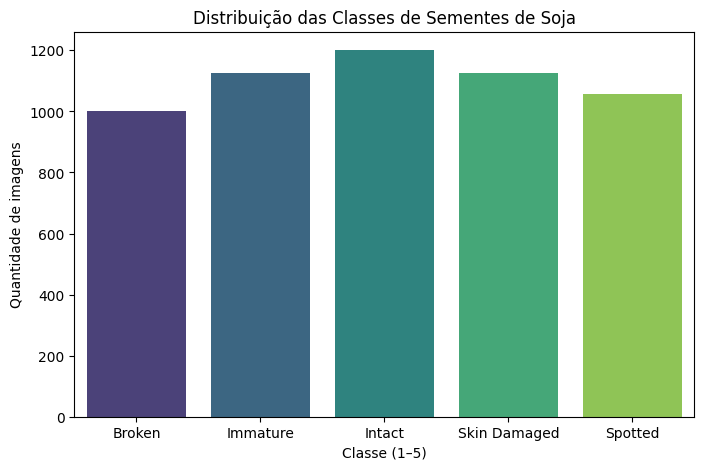

Valores faltantes no dataset: 0

Estatísticas descritivas (10 primeiras features):


,count,mean,std,min,25%,50%,75%,max
label,5513.0,3.020678,1.379513,1.000000,2.000000,3.000000,4.000000,5.000000
1,5513.0,0.034132,0.009091,0.013099,0.026723,0.034427,0.040831,0.066196
2,5513.0,0.007457,0.002029,0.002872,0.005997,0.007239,0.008675,0.021289
3,5513.0,0.003053,0.001099,0.000699,0.002212,0.002989,0.003784,0.008481
4,5513.0,0.006857,0.001976,0.002096,0.005414,0.006656,0.008034,0.016263
5,5513.0,0.003223,0.001148,0.000446,0.002348,0.003202,0.004017,0.007646
6,5513.0,0.007939,0.002174,0.001844,0.006365,0.007724,0.009296,0.018223
7,5513.0,0.003522,0.001294,0.000699,0.002503,0.003493,0.004405,0.007763
8,5513.0,0.007533,0.002205,0.002115,0.005938,0.007297,0.008946,0.018009
9,5513.0,0.003318,0.001169,0.000679,0.002406,0.003299,0.004134,0.007549


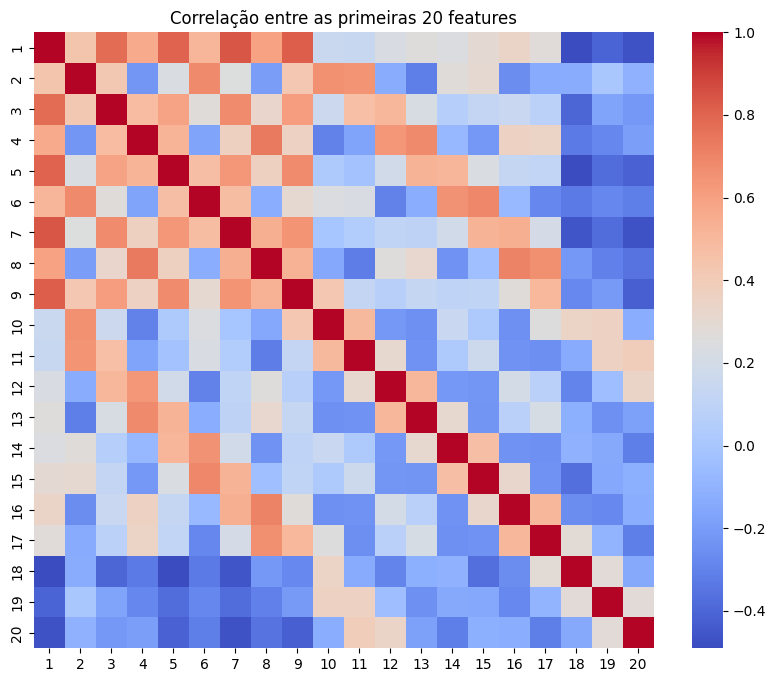

In [8]:
# EDA

# Carregar o dataset de features
df = pd.read_csv('./features_full.csv')

# Renomear a primeira coluna para "label"
df.rename(columns={df.columns[0]: 'label'}, inplace=True)

# Informações gerais
print("Informações gerais:")
print(df.info(), "\n")

print("Dimensões do dataset:", df.shape)
print("Amostra dos dados:")
display(df.head())

label_map = {
    1: "Broken",
    2: "Immature",
    3: "Intact",
    4: "Skin Damaged",
    5: "Spotted"
}

df['label_name'] = df['label'].map(label_map)

# Distribuição das classes
plt.figure(figsize=(8, 5))
sns.countplot(x='label_name', data=df, palette='viridis')
plt.title("Distribuição das Classes de Sementes de Soja")
plt.xlabel("Classe (1–5)")
plt.ylabel("Quantidade de imagens")
plt.show()

# Verificar valores faltantes
missing = df.isnull().sum().sum()
print(f"Valores faltantes no dataset: {missing}")

# Estatísticas descritivas básicas
print("\nEstatísticas descritivas (10 primeiras features):")
display(df.describe().T.head(10))

# Correlação entre as primeiras 20 features
plt.figure(figsize=(10, 8))
sns.heatmap(df.iloc[:, 1:21].corr(), cmap='coolwarm')
plt.title("Correlação entre as primeiras 20 features")
plt.show()

In [13]:
# Pré-processamento

# Separar features (X) e rótulos (y)
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['label']) # todas as colunas exceto a label
y = df['label'].values

# Dividir entre treino e teste (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização dos dados (média=0, desvio padrão=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Pré-processamento concluído")
print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Pré-processamento concluído
Tamanho do treino: (4410, 315)
Tamanho do teste: (1103, 315)


Acurácia dos modelos:
SVM: 0.6664
Regressão Logística (Baseline): 0.6165

Relatório de classificação - SVM:
              precision    recall  f1-score   support

      Broken       0.63      0.52      0.57       200
    Immature       0.63      0.63      0.63       225
      Intact       0.70      0.77      0.73       240
Skin Damaged       0.75      0.69      0.72       226
     Spotted       0.62      0.70      0.66       212

    accuracy                           0.67      1103
   macro avg       0.67      0.66      0.66      1103
weighted avg       0.67      0.67      0.66      1103


Relatório de classificação - Regressão Logística:
              precision    recall  f1-score   support

      Broken       0.58      0.56      0.57       200
    Immature       0.56      0.61      0.59       225
      Intact       0.63      0.67      0.65       240
Skin Damaged       0.66      0.57      0.61       226
     Spotted       0.65      0.67      0.66       212

    accuracy              

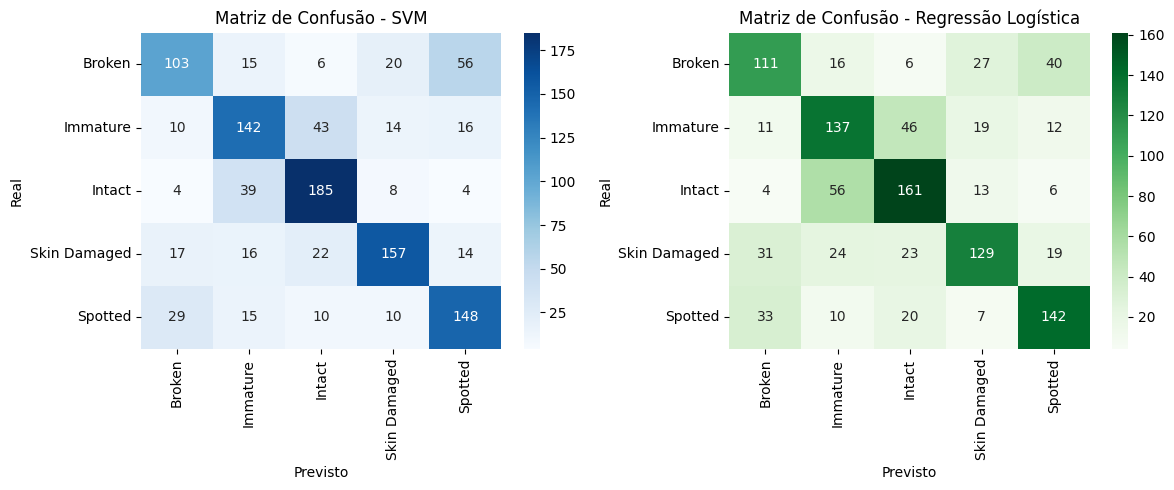

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Treinamento e Predição

# Mapeamento
label_map = {
    1: "Broken",
    2: "Immature",
    3: "Intact",
    4: "Skin Damaged",
    5: "Spotted"
}

# Modelo principal: SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Baseline: Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Avaliação
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_log = accuracy_score(y_test, y_pred_log)

print("Acurácia dos modelos:")
print(f"SVM: {acc_svm:.4f}")
print(f"Regressão Logística (Baseline): {acc_log:.4f}")

# --- Relatórios com nomes das classes ---
target_names = [label_map[i] for i in sorted(label_map.keys())]

print("\nRelatório de classificação - SVM:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

print("\nRelatório de classificação - Regressão Logística:")
print(classification_report(y_test, y_pred_log, target_names=target_names))

# Matriz de confusão para comparação visual
plt.figure(figsize=(12,5))

# SVM
plt.subplot(1, 2, 1)
sns.heatmap(
    confusion_matrix(y_test, y_pred_svm),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=target_names, yticklabels=target_names
)
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Regressão Logística
plt.subplot(1, 2, 2)
sns.heatmap(
    confusion_matrix(y_test, y_pred_log),
    annot=True, fmt='d', cmap='Greens',
    xticklabels=target_names, yticklabels=target_names
)
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')

plt.tight_layout()
plt.show()